In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score, cross_val_predict
import xgboost as xgb
import lightgbm as lgb
from tabpfn import TabPFNClassifier
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import optuna
import plotly.graph_objects as go
import seaborn as sns


In [7]:
df_completo = pd.read_csv(r"C:\Users\alefs\OneDrive\Documentos\GitHub\tcp\01_dados\data_mobilidade_V3.csv")

list(df_completo.columns)

['Unnamed: 0',
 'id',
 'id_seq',
 'transicao',
 'renda_depois',
 'V1023',
 'idade',
 'genero',
 'VD3004',
 'V2010',
 'UF',
 'ensino_medio',
 'ensino_superior',
 'anos_estudos',
 'raça',
 'posicao_familiar',
 'regiao',
 'tempo_desemprego']

In [8]:
# Defina os intervalos
bins = list(range(1, 25, 3)) + [float('inf')]
labels = [f'{i}-{i+2}' for i in range(1, 25, 3)]
labels[-1] = '25 ou mais'

# Crie a nova coluna com os intervalos
df_completo['intervalo_tempo_desemprego'] = pd.cut(
    df_encod['tempo_desemprego'],
    bins=bins,
    labels=labels,
    right=True
)

df_completo

,Unnamed: 0,id,id_seq,transicao,renda_depois,V1023,idade,genero,VD3004,V2010,UF,ensino_medio,ensino_superior,anos_estudos,raça,posicao_familiar,regiao,tempo_desemprego,intervalo_tempo_desemprego
0,1,130022706_13_11_15_05_2003_Mulher_1310211,650,Migrou para o setor privado,1650.0,Capital,20,Mulher,Superior incompleto ou equivalente,Parda,Amazonas,Ensino médio completo,Sem superior completo,14,Não branco,Não responsável pelo domicílio,Norte,18,16-18
1,2,130034554_02_11_26_11_1983_Mulher_1310211,653,Migrou para o setor privado,1606.0,Capital,39,Mulher,Médio completo ou equivalente,Parda,Amazonas,Ensino médio completo,Sem superior completo,12,Não branco,Não responsável pelo domicílio,Norte,24,25 ou mais
2,3,130035831_04_11_13_05_1996_Mulher_1310212,730,Migrou para TCP,710.0,Capital,27,Mulher,Médio incompleto ou equivalente,Parda,Amazonas,Ensino médio incompleto,Sem superior completo,11,Não branco,Não responsável pelo domicílio,Norte,24,25 ou mais
3,4,130053417_02_11_18_10_2004_Mulher_1351010,893,Migrou para o setor privado,1006.0,"Resto da UF (Unidade da Federação, excluindo ...",18,Mulher,Médio completo ou equivalente,Parda,Amazonas,Ensino médio completo,Sem superior completo,12,Não branco,Não responsável pelo domicílio,Norte,3,1-3
4,5,150029326_06_11_28_11_1997_Homem_1510011,1322,Migrou para o setor privado,1366.0,Capital,25,Homem,Médio completo ou equivalente,Branca,Pará,Ensino médio completo,Sem superior completo,12,Branco,Não responsável pelo domicílio,Norte,8,7-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,434,530005419_01_11_25_01_1995_Homem_5310112,64016,Migrou para TCP,5500.0,Capital,29,Homem,Superior completo,Branca,Distrito Federal,Ensino médio completo,Superior completo,16,Branco,Não responsável pelo domicílio,Centro-Oeste,24,25 ou mais
434,435,530017886_12_11_28_07_2005_Mulher_5310211,64125,Migrou para o setor privado,1412.0,Capital,18,Mulher,Médio completo ou equivalente,Parda,Distrito Federal,Ensino médio completo,Sem superior completo,12,Não branco,Não responsável pelo domicílio,Centro-Oeste,6,4-6
435,436,530003433_10_11_16_06_1991_Mulher_5310212,64220,Migrou para TCP,700.0,Capital,32,Mulher,Superior completo,Preta,Distrito Federal,Ensino médio completo,Superior completo,16,Não branco,Não responsável pelo domicílio,Centro-Oeste,48,25 ou mais
436,437,530031630_06_11_24_05_1986_Homem_5310212,64263,Migrou para TCP,2750.0,Capital,37,Homem,Superior completo,Parda,Distrito Federal,Ensino médio completo,Superior completo,15,Não branco,Não responsável pelo domicílio,Centro-Oeste,3,1-3


In [9]:
df_completo = df_completo.drop(['Unnamed: 0', 'renda_depois', 'UF', 'id', 'id_seq', 'ensino_medio', 
                                'ensino_superior', 'VD3004', 'raça', 'tempo_desemprego'], axis = "columns")
df_completo['transicao'] = df_completo['transicao'].map({'Migrou para TCP': 1, "Migrou para o setor privado": 0})
df_completo['genero'] = df_completo['genero'].map({'Homem': 1, "Mulher": 0})
df_completo['posicao_familiar'] = df_completo['posicao_familiar'].map({'Responsável pelo domicílio': 1,
                                                                      'Não responsável pelo domicílio': 0})

# Encoder
drop_enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Ajuste e transformação
df_completo_encoded = pd.DataFrame(
    drop_enc.fit_transform(df_completo[['regiao', 'V2010', 'V1023', 'intervalo_tempo_desemprego']]),
    columns=drop_enc.get_feature_names_out(['regiao', 'V2010', 'V1023', 'intervalo_tempo_desemprego']),
    index=df_completo.index
)

# Substituir no original
df_encod = df_completo.drop(columns=['regiao', 'V2010', 'V1023', 'intervalo_tempo_desemprego']).join(df_completo_encoded)

df_encod

,transicao,idade,genero,anos_estudos,posicao_familiar,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,V2010_Branca,...,"V1023_Resto da RM (Região Metropolitana, excluindo a capital)","V1023_Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",intervalo_tempo_desemprego_10-12,intervalo_tempo_desemprego_13-15,intervalo_tempo_desemprego_16-18,intervalo_tempo_desemprego_19-21,intervalo_tempo_desemprego_25 ou mais,intervalo_tempo_desemprego_4-6,intervalo_tempo_desemprego_7-9,intervalo_tempo_desemprego_nan
0,0,20,0,14,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,39,0,12,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,27,0,11,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,18,0,12,0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,25,1,12,0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,1,29,1,16,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
434,0,18,0,12,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
435,1,32,0,16,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
436,1,37,1,15,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
x = df_encod.drop(columns=['transicao'])
y = df_encod['transicao']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 42)

In [11]:
# Cria o scaler
scaler = StandardScaler()

# Ajusta o scaler apenas nos dados de treino
scaler.fit(X_train)

# Transforma os dados de treino e teste
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Aplica SMOTE apenas no treino
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanceado, y_train_balanceado = smote.fit_resample(X_train_scaled, y_train)

In [14]:
resultados_trials = []

def objective(trial):
    
    model_name = trial.suggest_categorical('model_name', [
        'Logistic Regression',
        'Decision Tree',
        'Random Forest',
        'LightGBM',
        'AdaBoost'     
    ])
    
    # Inicialização do modelo
    model = None
    
    if model_name == 'Logistic Regression':
        C = trial.suggest_float('logreg', 1e-3, 10, log=True)
        model = LogisticRegression(C=C, solver='lbfgs', 
                                   max_iter=1000, 
                                   random_state=42)
        
    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int("dt_max_depth", 2, 32)
        min_samples_split = trial.suggest_int('dt_min_sample_split', 2, 10)
        model = DecisionTreeClassifier(max_depth=max_depth, 
                                       min_samples_split=min_samples_split, 
                                       random_state=42)
        
    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('rf_n_estimators', 50, 300)
        max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        model = RandomForestClassifier(n_estimators=n_estimators, 
                                       max_depth=max_depth, 
                                       random_state=42)
        
    elif model_name == "LightGBM":
        n_estimators = trial.suggest_int("lgb_n_estimators", 50, 300)
        max_depth = trial.suggest_int("lgb_max_depth", 3, 10)
        learning_rate = trial.suggest_float("lgb_learning_rate", 0.01, 0.3)
        model = lgb.LGBMClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    learning_rate=learning_rate,
                                    random_state=42)
        
    elif model_name == 'AdaBoost':
        n_estimators = trial.suggest_int('ada_n_estimators', 50, 300)
        learning_rate = trial.suggest_float('ada_learning_rate', 0.01, 1)
        model = AdaBoostClassifier(n_estimators=n_estimators,
                                   learning_rate=learning_rate,
                                   random_state=42)

    #Cross-validation
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    y_pred_proba = cross_val_predict(model, X_train_scaled, y_train, cv = skf, method='predict_proba')
    y_pred = np.argmax(y_pred_proba, axis = 1)
    
    #Métricas
    acc = accuracy_score(y_train, y_pred)
    prec = precision_score(y_train, y_pred, average = 'macro')
    rec = recall_score(y_train, y_pred, average = 'macro')
    f1 = f1_score(y_train, y_pred, average = 'macro')
    logloss = log_loss(y_train, y_pred_proba)
    roc_auc = roc_auc_score(y_train, y_pred_proba[:, 1])
    
    # Armazenar resultados
    resultados_trials.append({
        'model_name': model_name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'log_loss': logloss,
        'roc_auc': roc_auc,
        **trial.params
    })

    return roc_auc  # porque optuna está maximizando

In [15]:
# Criando o objeto de estudo
study = optuna.create_study(direction='maximize',
                           sampler=optuna.samplers.TPESampler(seed=42))

# Iniciando a busca de hiperparâmetros
study.optimize(objective, n_trials=50)

# Mostra os resultados
print("Melhores hiperparâmetros:", study.best_trial.params)

#Transformando resultados em DataFrame
df_resultados = pd.DataFrame(resultados_trials)

#Ordenando pelo log-loss
df_resultados_ordenado = df_resultados.sort_values(by='roc_auc', ascending=False)
print(df_resultados_ordenado.head(10))

[I 2025-04-29 13:37:04,097] A new study created in memory with name: no-name-c46cc40a-0e62-43ba-874b-81344503c0ec
[I 2025-04-29 13:37:04,117] Trial 0 finished with value: 0.5503026634382567 and parameters: {'model_name': 'Decision Tree', 'dt_max_depth': 6, 'dt_min_sample_split': 2}. Best is trial 0 with value: 0.5503026634382567.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1

[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-04-2

[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\alefs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-29 13:37:10,088] Trial 12 finished with value: 0.5908595641646489 and parameters: {'model_name': 'Logistic Regression', 'logreg': 0.0011200687440843903}. Best is trial 11 with value: 0.6543886198547215.
[I 2025-04-29 13:37:10,173] Trial 13 finished with value: 0.6528753026634383 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 139, 'lgb_max_depth': 4, 'lgb_learning_rate': 0.01818772612829411}. Best is trial 11 with value: 0.6543886198547215.


[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-29 13:37:10,722] Trial 14 finished with value: 0.6190677966101696 and parameters: {'model_name': 'Random Forest', 'rf_n_estimators': 110, 'rf_max_depth': 17}. Best is trial 11 with value: 0.6543886198547215.
[I 2025-04-29 13:37:10,848] Trial 15 finished with value: 0.6059322033898306 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 272, 'lgb_max_depth': 3, 'lgb_learning_rate': 0.23952610635248622}. Best is trial 11 with value: 0.6543886198547215.


[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-29 13:37:10,963] Trial 16 finished with value: 0.6427360774818403 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 180, 'lgb_max_depth': 4, 'lgb_learning_rate': 0.01791338328022502}. Best is trial 11 with value: 0.6543886198547215.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-29 13:37:12,430] Trial 17 finished with value: 0.6273607748184019 and parameters: {'model_name': 'Random Forest', 'rf_n_estimators': 297, 'rf_max_depth': 32}. Best is trial 11 with value: 0.6543886198547215.
[I 2025-04-29 13:37:12,459] Trial 18 finished with value: 0.5585956416464891 and parameters: {'model_name': 'Logistic Regression', 'logreg': 8.750669272539461}. Best is trial 11 with value: 0.6543886198547215.
[I 2025-04-29 13:37:12,544] Trial 19 finished with value: 0.6233050847457626 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 128, 'lgb_max_depth': 5, 'lgb_learning_rate': 0.15679559387280043}. Best is trial 11 with value: 0.6543886198547215.
[I 2025-04-29 13:37:12,661] Trial 20 finished with value: 0.6284503631961259 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 222, 'lgb_max_depth': 5, 'lgb_learning_rate': 0.09964789132396251}. Best is trial 11 with value: 0.6543886198547215.


[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-29 13:37:12,778] Trial 21 finished with value: 0.6635290556900726 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 121, 'lgb_max_depth': 7, 'lgb_learning_rate': 0.012736852018817631}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:12,868] Trial 22 finished with value: 0.6620157384987894 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 123, 'lgb_max_depth': 8, 'lgb_learning_rate': 0.013170856712815697}. Best is trial 21 with value: 0.6635290556900726.


[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-29 13:37:12,944] Trial 23 finished with value: 0.6556295399515739 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 78, 'lgb_max_depth': 9, 'lgb_learning_rate': 0.07697231953230957}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:13,011] Trial 24 finished with value: 0.648547215496368 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 62, 'lgb_max_depth': 9, 'lgb_learning_rate': 0.08642465217541746}. Best is trial 21 with value: 0.6635290556900726.


[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\alefs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-29 13:37:13,264] Trial 25 finished with value: 0.6444309927360774 and parameters: {'model_name': 'Random Forest', 'rf_n_estimators': 53, 'rf_max_depth': 2}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:13,287] Trial 26 finished with value: 0.5783898305084746 and parameters: {'model_name': 'Logistic Regression', 'logreg': 0.09902845688494667}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:13,362] Trial 27 finished with value: 0.6464891041162227 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 93, 'lgb_max_depth': 10, 'lgb_learning_rate': 0.0654992759450206}. Best is trial 21 with value: 0.6635290556900

[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-29 13:37:13,607] Trial 30 finished with value: 0.6258474576271186 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 145, 'lgb_max_depth': 8, 'lgb_learning_rate': 0.12078553956482799}. Best is trial 21 with value: 0.6635290556900726.


[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-29 13:37:13,723] Trial 31 finished with value: 0.6561440677966103 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 210, 'lgb_max_depth': 6, 'lgb_learning_rate': 0.010690341788817797}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:13,843] Trial 32 finished with value: 0.6473365617433414 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 215, 'lgb_max_depth': 6, 'lgb_learning_rate': 0.04632208840588439}. Best is trial 21 with value: 0.6635290556900726.


[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-29 13:37:13,970] Trial 33 finished with value: 0.6554479418886199 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 219, 'lgb_max_depth': 9, 'lgb_learning_rate': 0.011073122919576496}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:14,038] Trial 34 finished with value: 0.6469733656174333 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 78, 'lgb_max_depth': 7, 'lgb_learning_rate': 0.05155405028246267}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:14,122] Trial 35 finished with value: 0.6213075060532688 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 113, 'lgb_max_depth': 8, 'lgb_learning_rate': 0.20035486242971084}. Best is trial 21 with value: 0.6635290556900726.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-04-2

[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-29 13:37:15,958] Trial 42 finished with value: 0.6556295399515738 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 225, 'lgb_max_depth': 10, 'lgb_learning_rate': 0.03752391568129327}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:16,084] Trial 43 finished with value: 0.5837772397094431 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 205, 'lgb_max_depth': 10, 'lgb_learning_rate': 0.29979510835429424}. Best is trial 21 with value: 0.6635290556900726.


[LightGBM] [Info] Number of positive: 53, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230435 -> initscore=-1.205858
[LightGBM] [Info] Start training from score -1.205858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-29 13:37:16,221] Trial 44 finished with value: 0.65090799031477 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 244, 'lgb_max_depth': 10, 'lgb_learning_rate': 0.0383194473954573}. Best is trial 21 with value: 0.6635290556900726.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-04-29 13:37:16,583] Trial 45 finished with value: 0.6206719128329299 and parameters: {'model_name': 'AdaBoost', 'ada_n_estimators': 55, 'ada_learning_rate': 0.7809927679825851}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:16,6

[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-29 13:37:16,797] Trial 47 finished with value: 0.6548426150121065 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 197, 'lgb_max_depth': 7, 'lgb_learning_rate': 0.07217746174159767}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:16,930] Trial 48 finished with value: 0.6493946731234868 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 240, 'lgb_max_depth': 9, 'lgb_learning_rate': 0.03558879321636534}. Best is trial 21 with value: 0.6635290556900726.
[I 2025-04-29 13:37:16,957] Trial 49 finished with value: 0.5337167070217919 and parameters: {'model_name': 'Decision Tree', 'dt_max_depth': 16, 'dt_min_sample_split': 8}. Best is trial 21 with value: 0.6635290556900726.


[LightGBM] [Info] Number of positive: 52, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227074 -> initscore=-1.224906
[LightGBM] [Info] Start training from score -1.224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [29]:
melhores_parametros = study.best_trial.params

modelo_final = RandomForestClassifier(n_estimators = 268, max_depth = 32)

modelo_final.fit(X_train_balanceado, y_train_balanceado)

RandomForestClassifier(max_depth=32, n_estimators=268)

In [30]:
y_pred = modelo_final.predict(X_test)
y_prob = modelo_final.predict_proba(X_test)[:, 1]

# Avaliar o desempenho
print("Avaliação no conjunto de teste:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Log Loss:", log_loss(y_test, y_prob))

Avaliação no conjunto de teste:
Accuracy: 0.22727272727272727
Precision: 0.22727272727272727
Recall: 1.0
F1 Score: 0.37037037037037035
ROC AUC: 0.36339869281045756
Log Loss: 1.3625468978766007


C:\Users\alefs\anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Melhor limiar pela curva ROC: 0.091
[[65 69]
 [12 23]]


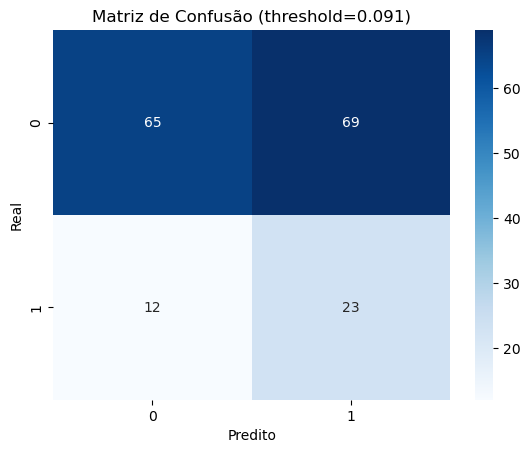

In [49]:
# 1. Gerar as probabilidades
y_proba = modelo_final.predict_proba(X_test)[:, 1]

# 2. Encontrar melhor limiar com base na curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
melhor_threshold = thresholds[ix]
print(f'Melhor limiar pela curva ROC: {melhor_threshold:.3f}')

# 3. Aplicar limiar
y_pred_threshold = (y_proba >= melhor_threshold).astype(int)

# 4. Matriz de confusão
matriz = confusion_matrix(y_test, y_pred_threshold)
print(matriz)

# 5. Plotar matriz
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão (threshold={melhor_threshold:.3f})')
plt.show()
